# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

#### Definir el tipo de proyecto

De acuerdo a las caracteristicas mencionadas del proycto, nos encontramos ante un objetivo de predicción a través de modelos de regresión.

#### Importación de librerias

In [1]:
# %pip install -U --user scikit-learn
# %pip install -U --user pmdarima
# %pip install -U --user Prophet
# %pip install -U --user Pandas
# %pip install -U --user catboost
# %pip install -U --user xgboost

In [2]:

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from pmdarima.arima import auto_arima
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from prophet import Prophet
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import pandas as pd
import math
import numpy as np
import time

#### Importación de DataFrame

In [3]:
# df = pd.read_csv('/datasets/taxi.csv',index_col='datetime', parse_dates=[0])
df = pd.read_csv('D:/Tripleten/datasets/taxi.csv', index_col='datetime', parse_dates=[0] ) # Local version
df.sort_index(inplace=True)

#### Visión general del df

In [4]:
print(df.head(), end='\n\n')
df.info()

                     num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


#### Revision de duplicados

In [5]:
df.index.duplicated().sum()

0

#### Revisión de valores nulos

De acuerdo con df.info() no existen valores nulos

#### Coherencia de datos

Los datos mantienen una tendencia de crecimiento, por el momento muestran coherencia.

In [6]:
df.resample('ME').sum().head(10)

num_orders
datetime              
2018-03-31       42768
2018-04-30       45939
2018-05-31       54820
2018-06-30       59906
2018-07-31       74405
2018-08-31       94973

#### El DF cubre un periodo total de 8 meses dividido por horas.

- [X] Identificar tipo de proyecto
- [X] Nombre de columna correcta
- [X] Clasificaciones de tipo de dato correctas
- [X] Dataframe sin duplicados
- [X] Excluir valores nulos
- [X] Verificar la coherencia de los datos

Conclusiones del proceso de preparación.

El conjunto de datos cargado mantiene una limpieza en sus datos (nombre de columna correctamente nombrados, coherencia de datos, inexistencia de duplicados y valores nulos ). Los datos cargados establecen un periodo desde el periodo 2018-03-01 hasta 2018-08-31.

## Análisis

In [7]:
# df.resample('YE').sum()
df_monthly = df.resample('ME').sum()
df_weekly = df.resample('W').sum()
df_daily = df.resample('D').sum()
df_hourly = df.resample('h').sum()

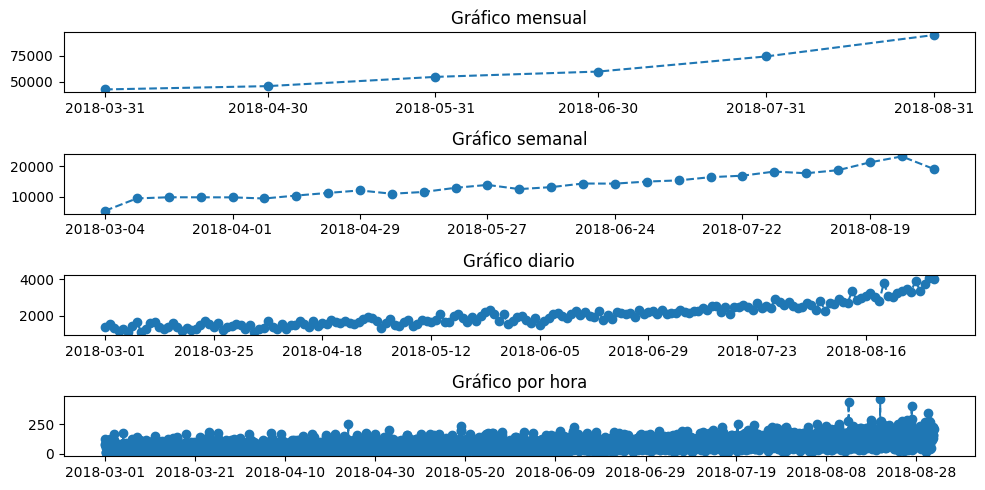

In [8]:
titles = ['Gráfico mensual', 'Gráfico semanal', 'Gráfico diario', 'Gráfico por hora']
interval = [1,4,24,480]

databases = [df_monthly,df_weekly,df_daily, df_hourly]
fig, axis = plt.subplots(4,1, figsize=[10,5])

for i, database in enumerate(databases):
    axis[i].plot(np.array(database.index), database.values, '--o')
    axis[i].set_title(titles[i])
    axis[i].set_xticks(database.index)
    axis[i].set_xticks(database.index[::interval[i]])

plt.tight_layout()
plt.show()

Como podemos observar, tenemos una tendencia de aumento en el número de pedidos mes con mes. Analicemos si existe una estacionalidad.

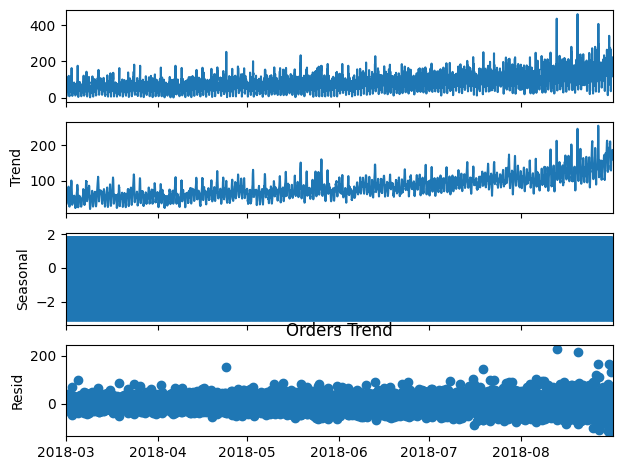

In [9]:
decomposed = seasonal_decompose(df_hourly, model='additive', period=7)
decomposed.plot()
plt.title('Orders Trend')
plt.show()

Como podemos observar, tenemos una tendencia de aumento y una estacionalidad cerca de 0

## Formación

Definiendo función para crear mas columnas de información

In [10]:
def make_features(df, lag, rolling_mean_size):
    '''Esta función tomará una serie temporal y creara columnas para aumentar su posibilidad de predicción
     en modelos de machine learning, generará columnas de año, mes, día, día de la semana y generará desfaces en los valores definidos 
    por la entrada, también generará una columna con el promedio móvil'''

    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek

    n_lag = lag
    for _ in range(3):
        df[f'lag_{n_lag}'] = df['num_orders'].shift(n_lag)
        n_lag = n_lag*2

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(df_hourly,6,3)

df_hourly.dropna(inplace=True)


# df_hourly.index.values[-1]

In [11]:

def train_split(df):
    y= df['num_orders']
    X= df.drop(columns='num_orders')

    X_train, X_test, y_train, y_test = train_test_split(X,y,shuffle=False, test_size=1/10) #10% del conjuntos de datos inicial

    return X_train, X_test, y_train, y_test

## Prueba

In [12]:
times = []

#### Machine_model_regressor 

In [13]:

def machine_model_regressor(df, model,params):

    #Start recording time
    start_time = time.time()

    #Train_test_split
    X_train, X_test, y_train, y_test = train_split(df)
    tscv = TimeSeriesSplit(n_splits=2)

    # Creating the grid
    grid_search = GridSearchCV(estimator=model, param_grid=params, cv=tscv, scoring='neg_mean_squared_error')
    grid_search.fit(X_train,y_train)
    best_model = grid_search.best_estimator_

    # Predicting
    y_pred = best_model.predict(X_test)
    rmse_score = root_mean_squared_error(y_test, y_pred)

    #End time
    end_time = time.time()
    elapsed_time = end_time - start_time

    #Plot
    y_pred = y_pred.astype(int)
    plot_df = pd.DataFrame({'test': y_test.values, 'prediction':y_pred}, index=y_test.index)
    plot_df.plot(marker='o', linestyle='--')
    plt.show()
    print(f'Tiempo de ejecución {elapsed_time:.2f}')

    # last_features = X_test.iloc[-1:]
    # next_hour_predict = X_test.index.sort_values(ascending=False)[0]
    # # next_prediction = best_model.predict(next_period.reshape(-1,1))
    # print(f'El modelo predice {next_prediction} taxis')
    return rmse_score

#### Modelo Linear Regression

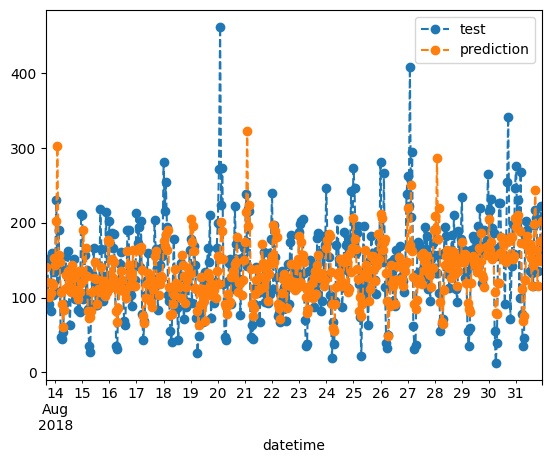

Tiempo de ejecución 0.05
RMSE para muestra es:48.77


In [14]:
model = LinearRegression()
params= {}
lr_score = machine_model_regressor(df_hourly, model, params)
print(f'RMSE para muestra es:{lr_score:.2f}')

#### Gradient Boosting Regressor

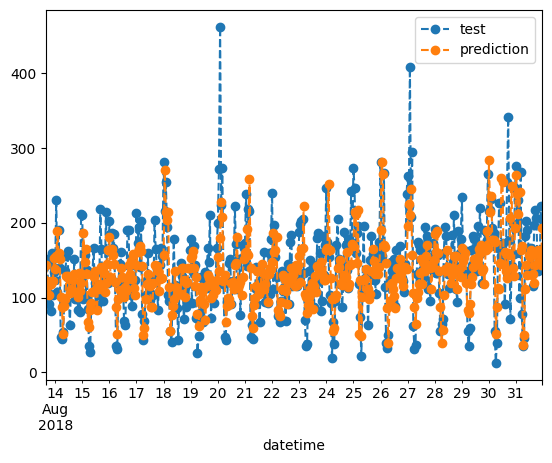

Tiempo de ejecución 83.87
RMSE para muestra es:48.80


In [15]:
params = {
    'learning_rate': [0.01, 0.05],
    'loss': ['squared_error'],
    'max_depth': [2,4,6],
    'min_samples_split':[2,4,6],
    'n_estimators':[100,200,500]
    }

model = GradientBoostingRegressor(random_state=12345)

gb_score = machine_model_regressor(df_hourly, model, params)
print(f'RMSE para muestra es:{gb_score:.2f}')

#### Catboost 

0:	learn: 30.1945877	total: 145ms	remaining: 2m 25s
1:	learn: 30.0571747	total: 147ms	remaining: 1m 13s
2:	learn: 29.9282246	total: 148ms	remaining: 49.3s
3:	learn: 29.7964236	total: 150ms	remaining: 37.3s
4:	learn: 29.6688881	total: 152ms	remaining: 30.2s
5:	learn: 29.5405119	total: 153ms	remaining: 25.4s
6:	learn: 29.4067469	total: 155ms	remaining: 22s
7:	learn: 29.2778600	total: 156ms	remaining: 19.4s
8:	learn: 29.1533017	total: 158ms	remaining: 17.4s
9:	learn: 29.0264891	total: 159ms	remaining: 15.8s
10:	learn: 28.9076119	total: 161ms	remaining: 14.5s
11:	learn: 28.7870541	total: 162ms	remaining: 13.4s
12:	learn: 28.6635494	total: 164ms	remaining: 12.5s
13:	learn: 28.5459562	total: 166ms	remaining: 11.7s
14:	learn: 28.4330773	total: 168ms	remaining: 11s
15:	learn: 28.3342000	total: 169ms	remaining: 10.4s
16:	learn: 28.2354494	total: 170ms	remaining: 9.86s
17:	learn: 28.1216207	total: 172ms	remaining: 9.38s
18:	learn: 28.0054133	total: 173ms	remaining: 8.96s
19:	learn: 27.8991439	to

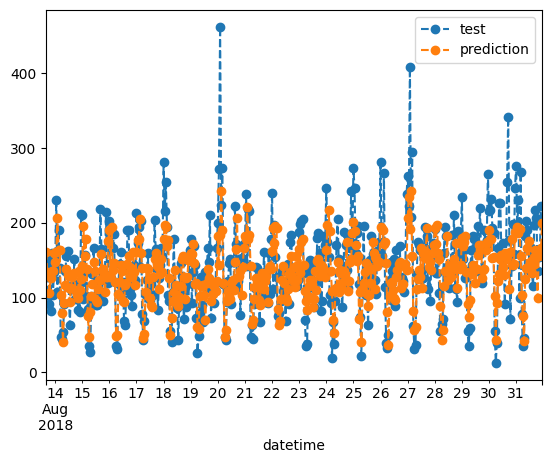

Tiempo de ejecución 230.26
RMSE para muestra es:44.66


In [16]:

params = {
'iterations':[1000, 1500],
'learning_rate': [0.01, 0.02, 0.03],
'depth':[6,7],
'l2_leaf_reg':[ 0.5, 1.0, 2.0],
'loss_function': ['RMSE']
}

model = CatBoostRegressor(random_state=12345)
cat_score = machine_model_regressor(df_hourly, model, params)
print(f'RMSE para muestra es:{cat_score:.2f}')

#### Modelo XG Boost

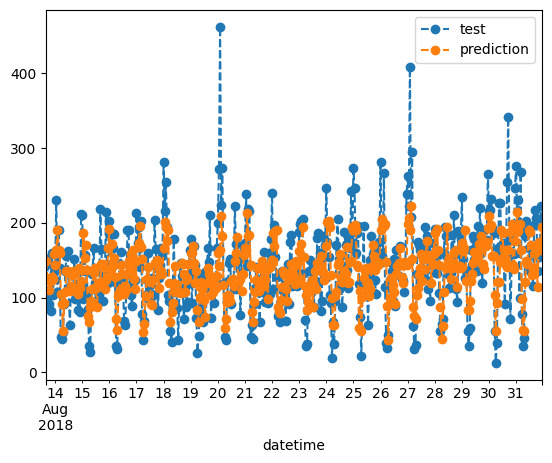

Tiempo de ejecución 20.23
RMSE para muestra es:46.09


In [17]:
model = XGBRegressor(random_state=12345)

params = {
# 'objective':['reg:squarederror'],
'learning_rate': [0.01, 0.05, 0.1],
'max_depth': [2,4,6],
'n_estimators':[100,200,1000]
    # gamma
    #lambda
    #alpha
}
xgb_score = machine_model_regressor(df_hourly, model, params)
print(f'RMSE para muestra es:{xgb_score:.2f}')

#### Modelo Auto Arima

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=4.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=39576.247, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=39199.876, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=39040.504, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=39574.249, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.97 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.53 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=5.23 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=39038.507, Time=0.75 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=1.34 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=1.88 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=39197.877, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=2.56 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 22.319 seconds


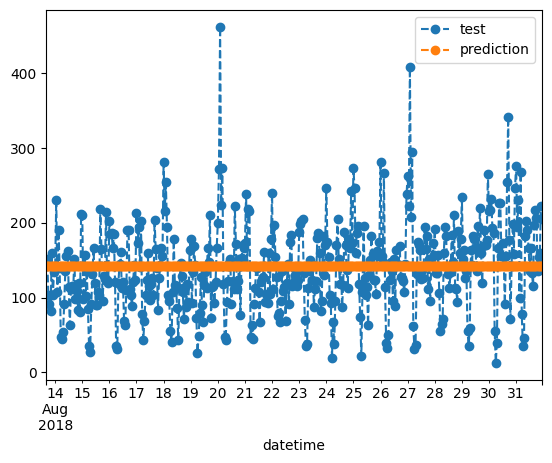

Tiempo de ejecución 22.39
RMSE para muestra es:58.73


In [18]:
df_arima = df_hourly['num_orders']

def arima(df_arima):
    start_time = time.time()
    train, test = train_test_split(df_arima, shuffle=False,test_size=1/10)
    model = auto_arima(train, seasonal=False, stepwise=True, trace=True)
    
    periods = len(test)
    y_pred = model.predict(n_periods=periods) 

    rmse_score = root_mean_squared_error(test.iloc[0:periods:], y_pred)

    end_time = time.time()
    elapsed_time = end_time - start_time
    y_pred = y_pred.astype(int)
    plot_df = pd.DataFrame({'test': test[0:periods].values, 'prediction':y_pred[0:periods]}, index=test.iloc[:periods].index)

    plot_df.plot(marker='o', linestyle='--')
    plt.show()

    print(f'Tiempo de ejecución {elapsed_time:.2f}')
    return rmse_score

arima_score = arima(df_arima)
print(f'RMSE para muestra es:{arima_score:.2f}')

#### Modelo Prophet (Meta)

08:46:57 - cmdstanpy - INFO - Chain [1] start processing
08:46:57 - cmdstanpy - INFO - Chain [1] done processing


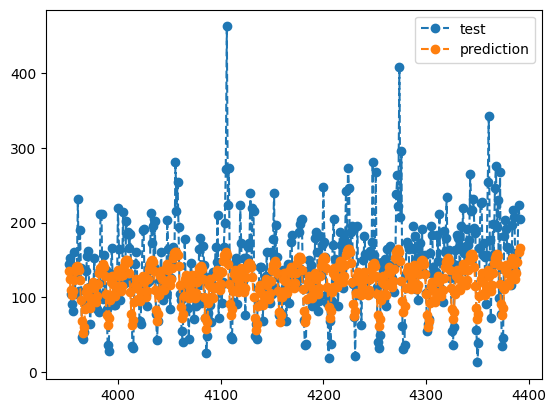

Tiempo de ejecución 2.72
RMSE para muestra es:48.26


In [19]:

def prophet(df_hourly):
    start_time = time.time()
    df_prophet = pd.DataFrame(data={"ds":df_hourly.index,"y":df_hourly['num_orders']})
    df_prophet = df_prophet.reset_index(drop=True)

    train, test = train_test_split(df_prophet, test_size=1/10, shuffle=False)

    model = Prophet()
    model.fit(train)

    # Realizar las predicciones para el conjunto de prueba
    future = model.make_future_dataframe(periods=len(test), freq='h')
    forecast = model.predict(future)

    y_pred = forecast['yhat'].tail(len(test))
    rmse_score = root_mean_squared_error(test['y'],y_pred)

    end_time = time.time()
    elapsed_time = end_time - start_time

    y_pred = y_pred.astype(int)
    plot_df = pd.DataFrame({'test': test['y'].values, 'prediction':y_pred.values}, index=test.index)

    plot_df.plot(marker='o', linestyle='--')
    plt.show()

    print(f'Tiempo de ejecución {elapsed_time:.2f}')
    return rmse_score

prophet_score = prophet(df_hourly)
print(f'RMSE para muestra es:{prophet_score:.2f}')

# Conclusiones
Los elementos obtenidos del dataset original abarcaban los meses de de Julio a Agosto, los elementos de fueron reclasificados de minutos a horas. Además, se observo una estacionalidad cercana a 0 y una tendencia de crecimiento.
Para el entrenamiento de los datos se utilizaron 6 modelos de machine learning con los siguientes resultados.

In [20]:
m_names = ['Linear_Regresion', 'GBoost', 'Catboost', 'XGboost', 'Arima', 'Prophet' ]
m_scores = [lr_score,gb_score,cat_score,xgb_score,arima_score,prophet_score]
results= pd.DataFrame(m_scores, index=m_names, columns=['model'])

results['model'] = round(results['model'])
results.sort_values(by='model', ascending=True)

model
Catboost           45.0
XGboost            46.0
Prophet            48.0
Linear_Regresion   49.0
GBoost             49.0
Arima              59.0

De acuerdo con la siguiente tabla podemos observar un mejor desempeño en el modelo de Catboost llevando una raíz de error cuadratico medio de 45 taxis, seguido por el modelo XGBoost y Prophet. Con estos resultados podemos asegurar el objetivo del proyecto.

# Lista de revisión

- [x]  Jupyter Notebook está abierto.
- [x]  El código no tiene errores
- [x]  Las celdas con el código han sido colocadas en el orden de ejecución.
- [x]  Los datos han sido descargados y preparados.
- [x]  Se ha realizado el paso 2: los datos han sido analizados
- [x]  Se entrenó el modelo y se seleccionaron los hiperparámetros
- [x]  Se han evaluado los modelos. Se expuso una conclusión
- [x]  La *RECM* para el conjunto de prueba no es más de 48


